# Projet modélidation stochastique
## Modèle 1

In [1]:
import pandas as pd
import os
import numpy as np
import sys
from sklearn.model_selection import train_test_split


ot_odr_filename = os.path.join(".", "OT_ODR.csv.bz2")
ot_odr_df = pd.read_csv(ot_odr_filename,
                        compression="bz2",
                        sep=";")

equipements_filename = os.path.join(".", 'EQUIPEMENTS.csv')
equipements_df = pd.read_csv(equipements_filename,
                             sep=";")

## Remplacement des tirets

In [2]:
ot_odr_df["SYSTEM_N2"].replace("-", "NONE", inplace=True)

In [3]:
var_cat = ['ODR_LIBELLE', 'TYPE_TRAVAIL',
           'SYSTEM_N1', 'SYSTEM_N2', 'SYSTEM_N3', 
           'SIG_ORGANE', 'SIG_CONTEXTE', 'SIG_OBS', 'LIGNE']
for var in var_cat:
    ot_odr_df[var] = ot_odr_df[var].astype('category')

ot_odr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506558 entries, 0 to 506557
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   OT_ID          506558 non-null  object  
 1   ODR_ID         506558 non-null  object  
 2   ODR_LIBELLE    506558 non-null  category
 3   TYPE_TRAVAIL   506558 non-null  category
 4   DUREE_TRAVAIL  506558 non-null  float64 
 5   SYSTEM_N1      506558 non-null  category
 6   SYSTEM_N2      506558 non-null  category
 7   SYSTEM_N3      506558 non-null  category
 8   EQU_ID         506558 non-null  object  
 9   DATE_OT        506558 non-null  object  
 10  KILOMETRAGE    506557 non-null  float64 
 11  SIG_ORGANE     506558 non-null  category
 12  SIG_CONTEXTE   506558 non-null  category
 13  SIG_OBS        506558 non-null  category
 14  LIGNE          506558 non-null  category
dtypes: category(9), float64(2), object(4)
memory usage: 29.7+ MB


## Création du modèle

In [4]:
import pyAgrum as gum

var_to_model = ["SYSTEM_N2", "SIG_OBS", "SIG_ORGANE"]

var_bn = {}
for var in var_to_model:
    nb_values = len(ot_odr_df[var].cat.categories)
    var_bn[var] = gum.LabelizedVariable(var, var, nb_values)

In [5]:
for var in var_bn:
    for i, modalite in enumerate(ot_odr_df[var].cat.categories):
        var_bn[var].changeLabel(i, modalite)

In [6]:
bn = gum.BayesNet("modèle simple")

for var in var_bn.values():
    bn.add(var)

In [7]:
bn.addArc("SIG_ORGANE", "SYSTEM_N2" )
bn.addArc("SIG_OBS", "SYSTEM_N2" )

In [8]:
import pyAgrum.lib.notebook as gnb 

bn

(pyAgrum.BayesNet<double>@0x107a2ee00) BN{nodes: 3, arcs: 2, domainSize: 307980, dim: 301309, mem: 2Mo 359Ko 472o}

## Séparation des données en données d'entrainement et de test

In [9]:
train, test = train_test_split(ot_odr_df, test_size=0.2, random_state=42)


## Entrainement du modèle

In [10]:
learner = gum.BNLearner(train[var_to_model])

learner.useSmoothingPrior(1)

learner.fitParameters(bn)

(pyAgrum.BNLearner<double>@0x106c15c00) Filename       : /var/folders/x6/jmv8lchn2_380sr18k25430h0000gn/T/tmpwbuz9s3c.csv
Size           : (405246,3)
Variables      : SYSTEM_N2[45], SIG_OBS[59], SIG_ORGANE[116]
Induced types  : True
Missing values : False
Algorithm      : MIIC
Score          : BDeu  (Not used for constraint-based algorithms)
Correction     : MDL  (Not used for score-based algorithms)
Prior          : Smoothing
Prior weight   : 1.000000

In [11]:
def predict(bn, data, var_target, show_progress=False):
    """
    This function is used to predict the posterior probability of a target variable from observations  
    using a bayesian network model. 

    Inputs:
    - =bn=: the predictive model given as a =pyAgrum.BayesNet= object
    - =data=: the data containing the observations used to predict the target variable 
    as a =pandas.DataFrame= object
    - =var_target=: the name of the target variable as a =str= object

    Returns:
    - a =DataFrame= containing the posterior probability distribution of the target 
    variable given each observation in =data=.
    """
    # Initialize the inference engine
    inf_bn = gum.LazyPropagation(bn)
    inf_bn.setTargets({var_target})
    nb_data = len(data)
    target_size = bn.variable(var_target).domainSize()
    target_dom = np.array([bn.variable(var_target).label(i)
                           for i in range(target_size)])
    data_records = data.to_dict("records")
    post_prob = np.zeros((nb_data, target_size))
    for i in range(nb_data):
        # Set the evidence
        inf_bn.setEvidence(data_records[i])
        # Run inference
        inf_bn.makeInference()
        # Compute posterior probability of target variable
        post_prob[i, :] = inf_bn.posterior(var_target).toarray()
        # Erase evidence
        inf_bn.eraseAllEvidence()
        if show_progress:
            sys.stdout.write("predict progress: {0:3.0%}\r".format(i/nb_data))

    post_prob_df = pd.DataFrame(post_prob,
                                index=data.index,
                                columns=bn.variable(var_target).labels())
    post_prob_df.columns.name = var_target
    return post_prob_df

## Prédiction de SYSTEM_N2


In [12]:
pred_prob = predict(bn,
                    data=test[["SIG_OBS", "SIG_ORGANE"]], 
                    var_target="SYSTEM_N2",
                    show_progress=True)

pred_var = pred_prob.idxmax(axis=1).rename("pred")

## Précision SYSTEM_N2

In [13]:
(test["SYSTEM_N2"] == pred_var).mean()

0.8283125394819962

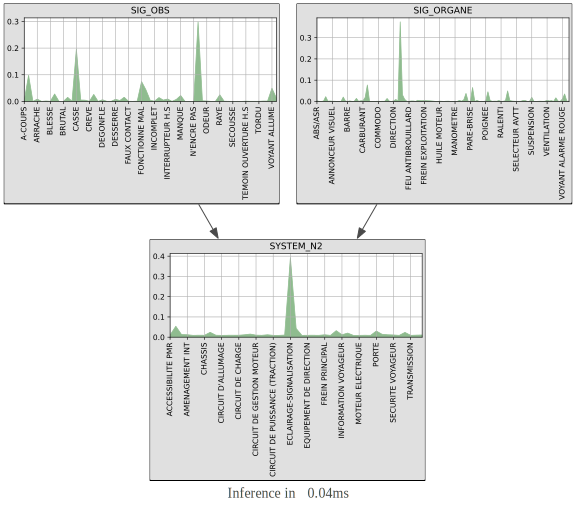

In [15]:
gnb.showInference(bn)


## Heatmap

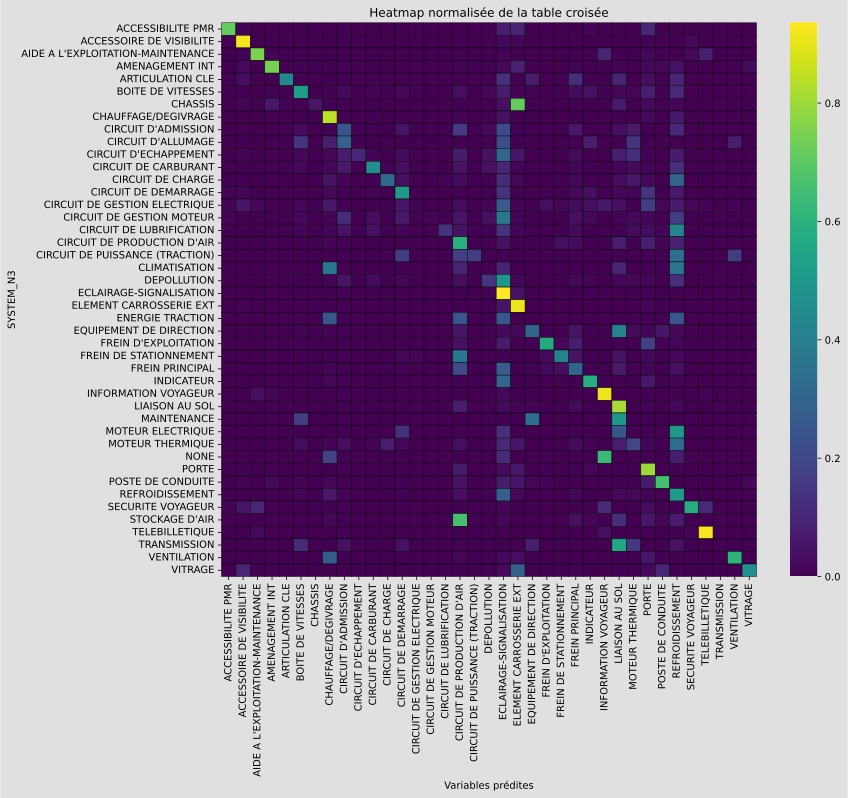

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Supposons que `test` est votre DataFrame et `pred_var` vos prédictions
# test = pd.DataFrame({...})
# pred_var = [...]

# Créer la table croisée
cross_tab = pd.crosstab(test["SYSTEM_N2"], pred_var)

# Normaliser la table croisée par ligne pour améliorer la lisibilité
cross_tab_normalized = cross_tab.div(cross_tab.sum(axis=1), axis=0)

# Afficher la table croisée normalisée avec seaborn heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cross_tab_normalized, annot=False, fmt=".2f", cmap="viridis", cbar=True, linewidths=.5, linecolor='black')

plt.title("Heatmap normalisée de la table croisée")
plt.xlabel("Variables prédites")
plt.ylabel("SYSTEM_N3")
plt.show()